## Pipeline for statistical data analysis

This cell must be executed to import all libraries and packages required for downstream analysis.

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xlsxwriter
from tools import connect, group, sum_by_var, count_unique, StatsForGraphs, Unpaired_ttest, MultipleComparison_ttest, Multiple_ttest, OneWayAnova, MathTextSciFormatter

### How to: Create connection to database and load data from table
Run this cell to connect to the database, load the data from the desired table, e.g., v12_platinum_158_dataset, and create a pandas data frame from it for downstream analysis. In the output of this cell, the first five rows of the table will be shown.

In [24]:
# Connect to database
cursor = connect()

# Load data from table V12_Platinum_158_dataset_All_stages
cursor.execute("SELECT * FROM v12_platinum_158_dataset")

# Obtain all rows of data table
v12_plat_158 = cursor.fetchall()

# Obtain column names
colnames = [desc[0] for desc in cursor.description]

# Create pandas DataFrame from list of tuples
df = pd.DataFrame(v12_plat_158)

# Add column names to respective columns
df.columns = colnames

# Display first five rows of pandas DataFrame
df.head()

Connecting to the PostgreSQL database...


,genotype,stage,pistil_id,ovule_id,cell_id,cell_type,cell_vol,cell_cycle
0,Col-0,1-II,290_7x,290_D,4163.0,L2,309.700,I
1,Col-0,1-II,290_7x,290_D,2154.0,L2,281.825,I
2,Col-0,1-II,290_7x,290_D,63.0,L2,237.621,I
3,Col-0,1-II,290_7x,290_D,3838.0,L2,232.475,I
4,Col-0,1-II,290_7x,290_D,1192.0,L1,212.399,I


### How to: Group data by variables, count unique values or sum up values in columns
Now, you can group the data by variables, e.g., by 'stage', count unique values in specified columns, e.g., 'ovule_id', and/or compute the sum of the values in specified columns. Note that before applying the functions sum_by_var, the dataframe has to be grouped first.

#### Example 1: Group by stage and count number of cells per ovule.

In [15]:
# Group by variable 'stage' (you can group by multiple variables, e.g., group(df, ['stage', 'ovule_id]))
df_by_stage = group(df, ['stage'])

# Count unique values in column 'ovule_id', i.e., count number of cells per ovule
count_by_stage = count_unique(df_by_stage, 'ovule_id')

# Display first five rows of resulting dataframe
count_by_stage.head()


,stage,ovule_id,n
0,1-I,783_A,46
1,1-I,784_A,38
2,1-I,784_B,45
3,1-I,784_D,39
4,1-I,785_A,39


#### Example 2: Group by stage and ovule ID and compute ovule volume

In [4]:
# Group by variables 'stage', 'ovule_id'
ovule_volume_by_stage = group(df, ['stage', 'ovule_id'])

# Sum up cell volumes, i.e., compute ovule volume
ovule_volume_by_stage = sum_by_var(ovule_volume_by_stage, 'cell_vol', 'volume')

# Display first five rows of resulting table
ovule_volume_by_stage.head()

,stage,ovule_id,volume
0,1-I,783_A,5273.1159
1,1-I,784_A,5118.4659
2,1-I,784_B,5755.6761
3,1-I,784_D,5650.7137
4,1-I,785_A,5501.2369


#### Example 3: Filter by cell cycle M, group by stage and count number of mitotic cells per ovule

In [16]:
# Filter for mitotic cells
mcells_by_stage = df[df['cell_cycle'] == 'M']

# Group by stage
mcells_by_stage = group(mcells_by_stage, ['stage'])

# Count number of mitotic cells per ovule
mcells_by_stage = count_unique(mcells_by_stage, 'ovule_id', 'n_mitotic')

# Display first five rows of resulting dataframe
mcells_by_stage.head()

,stage,ovule_id,n_mitotic
0,1-I,784_B,1
1,1-I,784_D,1
2,1-I,786_B,1
3,1-I,787_B,1
4,1-II,397_B,1


Compare overall number of cells per ovule to number of mitotic cells:

In [17]:
# Merge tables to display number of total cells and number of mitotic cells per ovule, grouped by stage

# Define grouping variables
gr = ['ovule_id', 'stage']

# Merge dataframes with a database-style join
count_by_stage = pd.merge(count_by_stage, mcells_by_stage, left_on=gr, right_on=gr, how='outer')

# Replace NaN values in variable "n_mitotic" by zero values and convert back to type "integer"
count_by_stage['n_mitotic'] = count_by_stage['n_mitotic'].fillna(0).astype('int64')

# Calculate ratio between overall number of cells and number of mitotic cells
count_by_stage['ratio'] = count_by_stage['n_mitotic'] / count_by_stage['n']

# Display first five rows of resulting dataframe
count_by_stage.head()

,stage,ovule_id,n,n_mitotic,ratio
0,1-I,783_A,46,0,0.000000
1,1-I,784_A,38,0,0.000000
2,1-I,784_B,45,1,0.022222
3,1-I,784_D,39,1,0.025641
4,1-I,785_A,39,0,0.000000


### How to: Visualization of results and statistical analyses
At this point, you might want to visualize and analyze the results. Here are some examples of how to visualize the data using error bar plots, indicating mean values and standard deviations, and scatter plots. To analyze the data, you might want to perform i) unpaired t-tests, ii) multiple t-tests or multiple comparison t-tests (multiple t-test with correction) and add corresponding annotations to the plots.

#### Example 1: Error bar plot, scatter plot, unpaired t-test

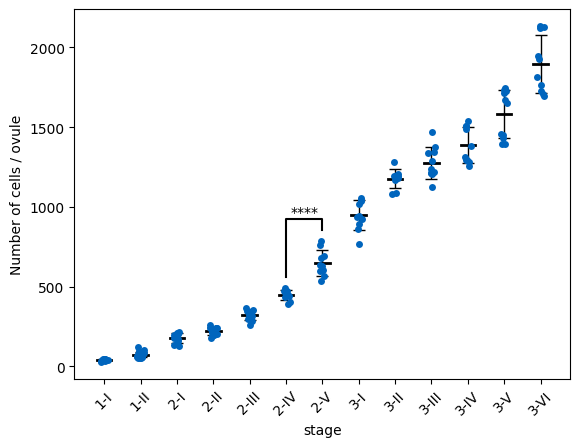

In [5]:
# Box plot of number of cells per ovule over stage

# Get statistics (mean, standard deviation)
stats = StatsForGraphs(count_by_stage, 'stage', 'n')
means, stds = stats.compute_stats()

# Error bar plot, indicating means and standard deviations
plt.errorbar(count_by_stage['stage'].unique(), means, yerr=stds, linestyle='None', lw=1.0, fmt='None', capsize=4.0, color='black')

for idx, stage in enumerate(count_by_stage['stage'].unique()):
    plt.plot([idx-0.2,idx+0.2], [means[idx],means[idx]], color='black', lw=2.0)

# Scatter plot, indicating individual data points
sns.stripplot(data=count_by_stage, x='stage', y='n', color='#0065bd', alpha=1.0)

# Perform unpaired t-test and add statistical annotation to plot
ttest = Unpaired_ttest(count_by_stage, var='stage', categories=['2-IV', '2-V'], value='n')
ast = ttest.perform_ttest()
ttest.graph_annotate(ast, col='black', h=70) # Choose h value according to measurement scale

# Change label of y-axis
plt.ylabel('Number of cells / ovule')

# Rotate x-axis labels
plt.xticks(rotation=45)

# Show plot
plt.show()

#### Example 2: Error bar plot, scatter plot, multiple t-test (unpaired, parametric)

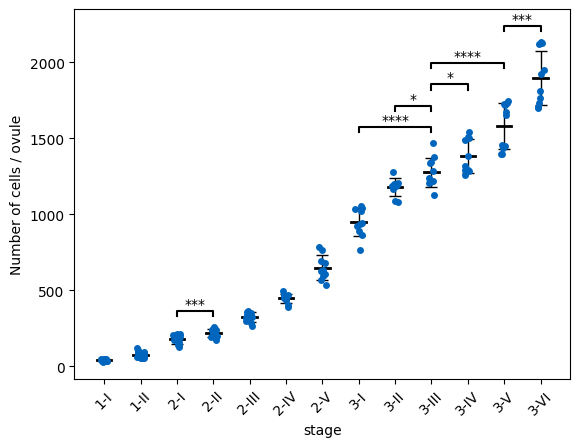

In [6]:
# Get statistics (mean, standard deviation)
stats = StatsForGraphs(count_by_stage, 'stage', 'n')
means, stds = stats.compute_stats()

# Error bar plot, indicating means and standard deviations
plt.errorbar(count_by_stage['stage'].unique(), means, yerr=stds, linestyle='None', lw=1.0, fmt='None', capsize=4.0, color='black')

for idx, stage in enumerate(count_by_stage['stage'].unique()):
    plt.plot([idx-0.2,idx+0.2], [means[idx],means[idx]], color='black', lw=2.0)

# Scatter plots
sns.stripplot(data=count_by_stage, x='stage', y='n', color='#0065bd', alpha=1.0)

# Perform multiple t-test (unpaired, parametric) and add statistical annotation to plot
# Specify data pairs as [('cat1','cat2'), ('cat1','cat2'), ..., ('cat1','cat2')]
pairs = [('2-I', '2-II'), ('3-I', '3-III'), ('3-II', '3-III'), ('3-III', '3-IV'), ('3-III', '3-V'), ('3-V', '3-VI')]
ttest = Multiple_ttest(count_by_stage, var='stage', value='n', pairs=pairs)
ast = ttest.perform_ttest()
ttest.graph_annotate(ast, col='black', h=70) # Choose h value according to measurement scale

# Change label of y-axis
plt.ylabel('Number of cells / ovule')

# Rotate x-axis labels
plt.xticks(rotation=45)

# Show plot
plt.show()

#### Example 3: Error bar plot, scatter plot, multiple comparison t-test with Holm-Sidak correction 

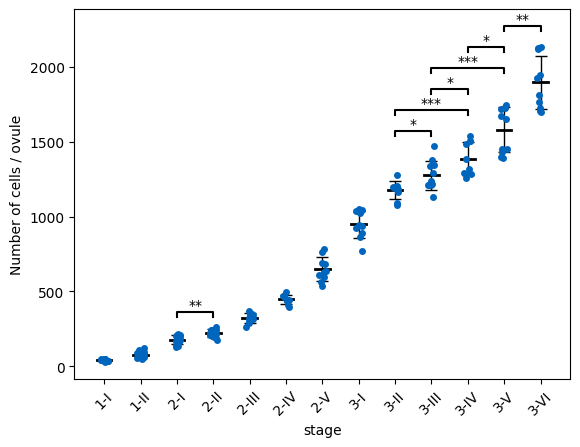

In [7]:
# Get statistics (mean, standard deviation)
stats = StatsForGraphs(count_by_stage, 'stage', 'n')
means, stds = stats.compute_stats()

# Error bar plot, indicating means and standard deviations
plt.errorbar(count_by_stage['stage'].unique(), means, yerr=stds, linestyle='None', lw=1.0, fmt='None', capsize=4.0, color='black')

for idx, stage in enumerate(count_by_stage['stage'].unique()):
    plt.plot([idx-0.2,idx+0.2], [means[idx],means[idx]], color='black', lw=2.0)

# Scatter plots
sns.stripplot(data=count_by_stage, x='stage', y='n', color='#0065bd', alpha=1.0)

# Perform multiple comparison t-test and add statistical annotation to plot
ttest = MultipleComparison_ttest(count_by_stage, var='stage', value='n', method='holm-sidak')
pairs, pvalues, ast = ttest.perform_ttest()
ttest.graph_annotate(pairs, ast, col='black', h=70) # Choose h value according to measurement scale

# Change label of y-axis
plt.ylabel('Number of cells / ovule')

# Rotate x-axis labels
plt.xticks(rotation=45)

# Show plot
plt.show()

#### Example 4: One-way ANOVA

In [8]:
# Specify categories for analysis
categories = ['3-II','3-III','3-IV']

# Perform one-way ANOVA
anova_test = OneWayAnova(count_by_stage, var='stage', value='n', category=categories)
st, p = anova_test.perform_anova()

# Print statistic and p-value
print(f'Statistic: {st}, p-value: {p}')

Statistic: 12.859638302912241, p-value: 0.0001092421548983739


#### Example 5: Error bar plot, scatter plot

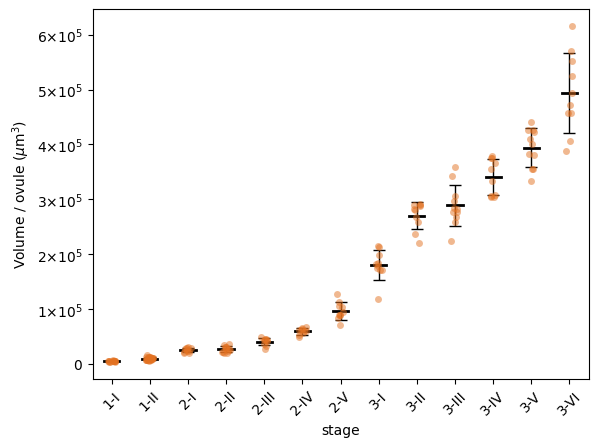

In [9]:
# Convert variable "cell_vol" from type decimal to type float
ovule_volume_by_stage['volume'] = ovule_volume_by_stage['volume'].astype('float')

# Init plot
fig, ax = plt.subplots()

# Get statistics (mean, standard deviation)
stats = StatsForGraphs(ovule_volume_by_stage, 'stage', 'volume')
means, stds = stats.compute_stats()

# Error bar plot, indicating means and standard deviations
plt.errorbar(ovule_volume_by_stage['stage'].unique(), means, yerr=stds, linestyle='None', lw=1.0, fmt='None', capsize=4.0, color='black')

for idx, stage in enumerate(ovule_volume_by_stage['stage'].unique()):
    plt.plot([idx-0.2,idx+0.2], [means[idx],means[idx]], color='black', lw=2.0)

# Scatter plots
sns.stripplot(data=ovule_volume_by_stage, x='stage', y='volume', color='#e37222', alpha=0.5)

# Y-axis formatter (scientific format)
plt.gca().yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))

# Change label of y-axis
plt.ylabel('Volume / ovule ($\mu$m$^3$)')

# Rotate x-axis labels
plt.xticks(rotation=45)

# Show plot
plt.show()

### How to: Filter data when loading from database
You might want to directly filter your data when loading it from the database. Here are some examples for demonstration.

#### Example 1: Filter by early stages (1-I until 2-IV)

In [20]:
# Connect to database
cursor = connect()

# Load data from table V12_Platinum_158_dataset_All_stages
# Filter by early stages (1-I until 2-IV)

cursor.execute("SELECT * FROM v12_platinum_158_dataset WHERE stage IN ('1-I','1-II','2-I','2-II','2-III','2-IV');")

# Obtain all rows of data table
v12_plat_158_early = cursor.fetchall()

# Obtain column names
colnames = [desc[0] for desc in cursor.description]

# Create pandas DataFrame from list of tuples
df = pd.DataFrame(v12_plat_158_early)

# Add column names to respective columns
df.columns = colnames

# Display first five rows of pandas DataFrame
df.head()

Connecting to the PostgreSQL database...


,genotype,stage,pistil_id,ovule_id,cell_id,cell_type,cell_vol,cell_cycle
0,Col-0,1-II,290_7x,290_D,4163.0,L2,309.700,I
1,Col-0,1-II,290_7x,290_D,2154.0,L2,281.825,I
2,Col-0,1-II,290_7x,290_D,63.0,L2,237.621,I
3,Col-0,1-II,290_7x,290_D,3838.0,L2,232.475,I
4,Col-0,1-II,290_7x,290_D,1192.0,L1,212.399,I


In [21]:
# Count unique values in variable "stage"
by_stage = count_unique(df, 'stage')
by_stage.head()

,index,n
0,1-I,554
1,1-II,2071
2,2-I,1946
3,2-II,2868
4,2-III,3241


#### Example 2: Filter by later stages (1-I until 2-IV)

In [22]:
# Connect to database
cursor = connect()

# Load data from table V12_Platinum_158_dataset_All_stages
# Filter by later stages (2-II until 3-VI)

cursor.execute("SELECT * FROM v12_platinum_158_dataset WHERE stage IN ('2-II','2-III','2-IV','2-V','3-I','3-II','3-III','3-IV','3-V','3-VI');")

# Obtain all rows of data table
v12_plat_158_late = cursor.fetchall()

# Obtain column names
colnames = [desc[0] for desc in cursor.description]

# Create pandas DataFrame from list of tuples
df = pd.DataFrame(v12_plat_158_late)

# Add column names to respective columns
df.columns = colnames

# Display first five rows of pandas DataFrame
df.head()

,genotype,stage,pistil_id,ovule_id,cell_id,cell_type,cell_vol,cell_cycle
0,Col-0,2-II,769,769,383.0,L2,836.147,I
1,Col-0,2-II,769,769,775.0,L3,407.212,I
2,Col-0,2-II,769,769,787.0,L3,319.006,I
3,Col-0,2-II,769,769,255.0,L3,310.791,I
4,Col-0,2-II,769,769,261.0,L2,279.569,M


In [21]:
# Count unique values in variable "stage"
by_stage = count_unique(df, 'stage')
by_stage.head()

,stage,n
0,2-II,2868
1,2-III,3241
2,2-IV,4471
3,2-V,6487
4,3-I,9481


#### Example 3: Filter by specific stage and cell type/layer

In [6]:
# Connect to database
cursor = connect()

# Load data from table V12_Platinum_158_dataset_All_stages
# Filter by specific stage and cell type/layer

cursor.execute("SELECT * FROM v12_platinum_158_dataset WHERE stage='1-I' AND cell_type='L1'")

# Obtain all rows of data table
v12_plat_158_1I_L1 = cursor.fetchall()

# Obtain column names
colnames = [desc[0] for desc in cursor.description]

# Create pandas DataFrame from list of tuples
df = pd.DataFrame(v12_plat_158_1I_L1)

# Add column names to respective columns
df.columns = colnames

# Display first five rows of pandas DataFrame
df.head()

,genotype,stage,pistil_id,ovule_id,cell_id,cell_type,cell_vol,cell_cycle
0,Col-0,1-I,783_5x,783_A,2180,L1,205.062,I
1,Col-0,1-I,783_5x,783_A,1260,L1,186.779,I
2,Col-0,1-I,783_5x,783_A,1841,L1,179.353,I
3,Col-0,1-I,783_5x,783_A,102,L1,158.205,I
4,Col-0,1-I,783_5x,783_A,1181,L1,156.158,I


In [7]:
# Count number of cells per ovule filtered by a specific stage and cell type/layer
per_ovule = count_unique(df, ['stage','ovule_id','cell_type'])
per_ovule.head()

,stage,ovule_id,cell_type,n
0,1-I,783_A,L1,30
1,1-I,784_A,L1,23
2,1-I,784_B,L1,29
3,1-I,784_D,L1,23
4,1-I,785_A,L1,23


### How to: Add labels/values according to label/value of specified variable
Sometimes, you might want to add additional columns containing labels/values dependent on other variables. Here is an example of adding parent and tissue labels according to the parent ID.

In [15]:
# Connect to database
cursor = connect()

# Load data from table 1793 cell_attributes
cursor.execute("SELECT * FROM cell_attributes_1793")

# Obtain all rows of data table
cell_attributes = cursor.fetchall()

# Obtain column names
colnames = [desc[0] for desc in cursor.description]

# Create pandas DataFrame from list of tuples
df = pd.DataFrame(cell_attributes)

# Add column names to respective columns
df.columns = colnames

# Display first five rows of pandas DataFrame
df.head()

Connecting to the PostgreSQL database...


,cell_id,parent_label,genotype,sample_id,stage,cell_length_x,cell_length_y,cell_length_z,cell_wall_area,neighbours,outside_wall_area,outside_wall_area_ratio,volume
0,1835,7,ChiOX,1793,3-IV,6.00088,5.29523,6.09765,148.201,3,108.7990,0.734131,142.288
1,1838,7,ChiOX,1793,3-IV,5.57317,4.97323,8.43972,147.736,7,105.3080,0.712816,131.511
2,1842,7,ChiOX,1793,3-IV,7.01422,5.10685,9.65658,205.962,9,101.4710,0.492667,228.485
3,1846,7,ChiOX,1793,3-IV,6.57697,4.84003,10.27570,221.655,13,114.5350,0.516727,245.790
4,1847,7,ChiOX,1793,3-IV,5.87977,5.71539,6.19016,135.858,7,69.4824,0.511433,132.188


In [16]:
# Add parent and tissue label according to parent ID
df['parent_name']=df['parent_label'].apply(lambda x: 'oi2' if x==1 else ('oi1' if x==2 else ('ii2' if x==3 else ('ii1' if x==4 else ('nu' if x==5 else ('PCh' if x==6 else ('fu' if x==7 else ('es' if x==8 else ('pl' if x==9 else 'ACh')))))))))
df['tissue_label'] = df['parent_label'].apply(lambda x: 'oi' if x==1 or x==2 else ('ii' if x==3 or x==4 else ('ch' if x==6 or x==10 else ('nu' if x==5 else ('fu' if x==7 else ('es' if x==8 else 'pl'))))))
df.head()

,cell_id,parent_label,genotype,sample_id,stage,cell_length_x,cell_length_y,cell_length_z,cell_wall_area,neighbours,outside_wall_area,outside_wall_area_ratio,volume,parent_name,tissue_label
0,1835,7,ChiOX,1793,3-IV,6.00088,5.29523,6.09765,148.201,3,108.7990,0.734131,142.288,fu,fu
1,1838,7,ChiOX,1793,3-IV,5.57317,4.97323,8.43972,147.736,7,105.3080,0.712816,131.511,fu,fu
2,1842,7,ChiOX,1793,3-IV,7.01422,5.10685,9.65658,205.962,9,101.4710,0.492667,228.485,fu,fu
3,1846,7,ChiOX,1793,3-IV,6.57697,4.84003,10.27570,221.655,13,114.5350,0.516727,245.790,fu,fu
4,1847,7,ChiOX,1793,3-IV,5.87977,5.71539,6.19016,135.858,7,69.4824,0.511433,132.188,fu,fu


Here are some more examples of how to group data by variables, or make use of the functions sum_by_var() and count_unique().

In [13]:
# Count unique values in variable "sample_id", i.e., count numbers of cells
count_by_sample = group(df, 'stage')
count_by_sample = count_unique(count_by_sample, 'sample_id', 'n')
count_by_sample

,stage,sample_id,n
0,3-IV,1793,1803


In [11]:
# Group by sample ID and stage and sum up the volume
volume_by_sample = group(df, ['sample_id', 'stage'])
volume_by_sample = sum_by_var(volume_by_sample, 'volume', 'volume')
volume_by_sample

,sample_id,stage,volume
0,1793,3-IV,549413.277647


In [17]:
# Group by sample ID, stage and tissue label and sum up the volume
tissue_volume_sample = group(df, ['stage', 'sample_id', 'tissue_label'])
tissue_volume_sample = sum_by_var(tissue_volume_sample, 'volume', 'volume')
tissue_volume_sample

,stage,sample_id,tissue_label,volume
0,3-IV,1793,ch,89611.349193
1,3-IV,1793,es,5820.900000
2,3-IV,1793,fu,84846.750602
3,3-IV,1793,ii,82750.520000
4,3-IV,1793,nu,13064.334550
5,3-IV,1793,oi,265555.296438
6,3-IV,1793,pl,7764.126864


In [6]:
# Group by sample_id and stage and count unique values in variable "parent_label", i.e., count number of cells according to parent label
count_parent_by_sample = group(df, ['sample_id', 'stage'])
count_parent_by_sample = count_unique(count_parent_by_sample, 'parent_label')
count_parent_by_sample

,sample_id,stage,parent_label,n
0,1793,3-IV,0,29
1,1793,3-IV,1,238
2,1793,3-IV,2,188
3,1793,3-IV,3,140
4,1793,3-IV,4,126
5,1793,3-IV,5,92
6,1793,3-IV,6,261
7,1793,3-IV,7,528
8,1793,3-IV,8,1
9,1793,3-IV,10,171


In [5]:
# Group by variables "stage" and count unique values in variable "sample_id", i.e., count number of cells per sample
count_sample_by_stage = group(df, 'stage')
count_sample_by_stage = count_unique(count_sample_by_stage, 'sample_id')
count_sample_by_stage

,stage,sample_id,n
0,3-IV,1793,1803


### How to: Export dataframe to excel
You might want to export your results to excel. Here is how to:

In [18]:
# create excel table from dataframe
tissue_volume_sample.to_excel("output.xlsx") # change the file name to your liking